In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

# Display basic information
print(customers.info())
print(products.info())
print(transactions.info())

# Check for missing values
print(customers.isnull().sum())
print(products.isnull().sum())
print(transactions.isnull().sum())

# Convert date columns to datetime
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Preview datasets
print(customers.head())
print(products.head())
print(transactions.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------

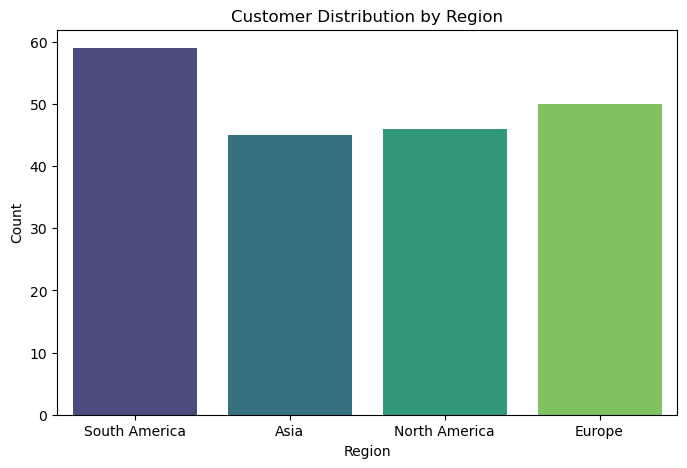

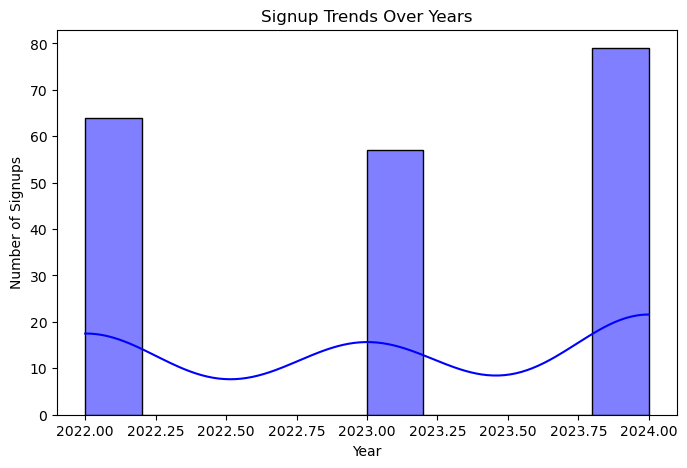

In [2]:
# Plot customer distribution by region
plt.figure(figsize=(8, 5))
sns.countplot(data=customers, x='Region', palette='viridis')
plt.title("Customer Distribution by Region")
plt.xlabel("Region")
plt.ylabel("Count")
plt.show()

# Analyze signup trends
customers['SignupYear'] = customers['SignupDate'].dt.year
plt.figure(figsize=(8, 5))
sns.histplot(data=customers, x='SignupYear', bins=10, kde=True, color='blue')
plt.title("Signup Trends Over Years")
plt.xlabel("Year")
plt.ylabel("Number of Signups")
plt.show()


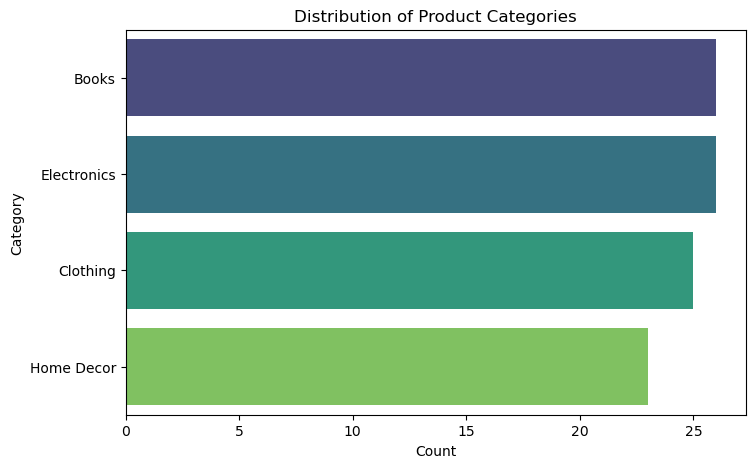

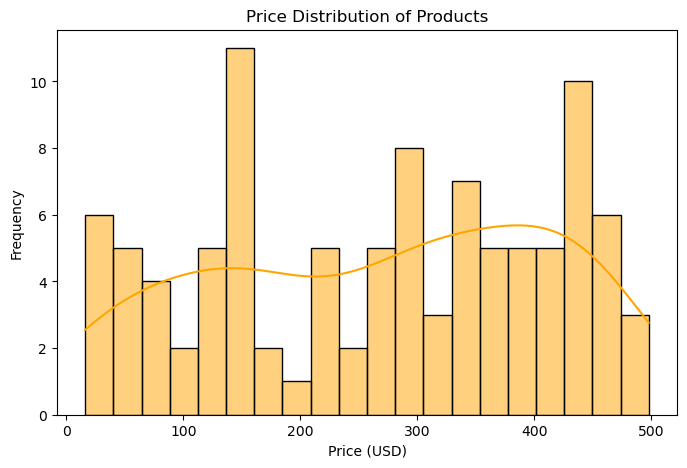

In [3]:
# Plot product categories
plt.figure(figsize=(8, 5))
sns.countplot(data=products, y='Category', palette='viridis', order=products['Category'].value_counts().index)
plt.title("Distribution of Product Categories")
plt.xlabel("Count")
plt.ylabel("Category")
plt.show()

# Analyze price distribution
plt.figure(figsize=(8, 5))
sns.histplot(data=products, x='Price', bins=20, kde=True, color='orange')
plt.title("Price Distribution of Products")
plt.xlabel("Price (USD)")
plt.ylabel("Frequency")
plt.show()


In [6]:
# Ensure TotalValue is numeric
transactions['TotalValue'] = pd.to_numeric(transactions['TotalValue'], errors='coerce')

# Ensure Month is a string or period type
transactions['Month'] = transactions['TransactionDate'].dt.to_period('M')

# Group by Month and recalculate monthly_sales
monthly_sales = transactions.groupby('Month')['TotalValue'].sum().reset_index()

# Verify data types again
print(monthly_sales.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype    
---  ------      --------------  -----    
 0   Month       13 non-null     period[M]
 1   TotalValue  13 non-null     float64  
dtypes: float64(1), period[M](1)
memory usage: 336.0 bytes
None


In [7]:
# Check for NaN values
print(monthly_sales.isnull().sum())

# Drop rows with NaN if any
monthly_sales = monthly_sales.dropna()

# Alternatively, fill missing values with 0
# monthly_sales['TotalValue'] = monthly_sales['TotalValue'].fillna(0)


Month         0
TotalValue    0
dtype: int64


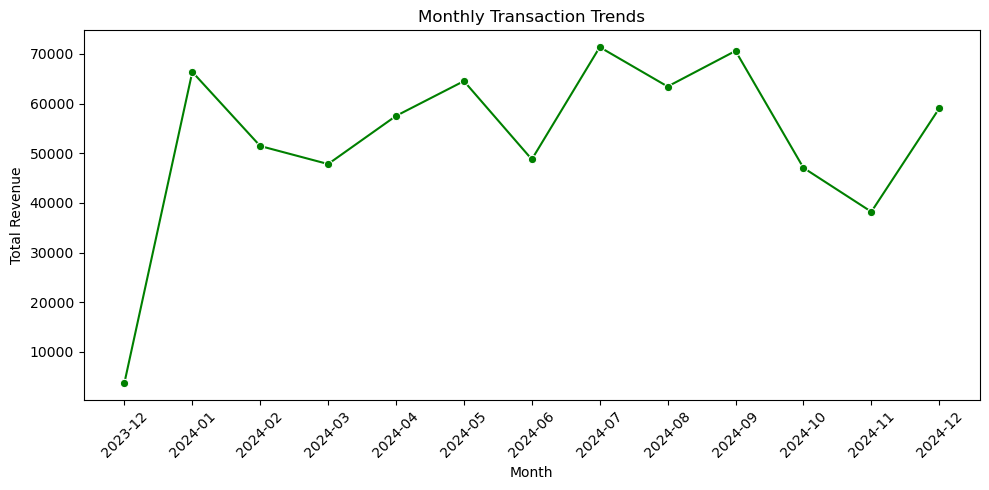

In [9]:
# Convert Month to string for plotting
monthly_sales['Month'] = monthly_sales['Month'].astype(str)

# Plot Monthly Transaction Trends
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_sales, x='Month', y='TotalValue', marker='o', color='green')
plt.title("Monthly Transaction Trends")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [12]:
# Step 1: Aggregate transaction data
customer_transactions = transactions.groupby('CustomerID').agg(
    TotalSpend=('TotalValue', 'sum'),
    TotalQuantity=('Quantity', 'sum'),
    TransactionCount=('TransactionID', 'count')
).reset_index()

# Step 2: Merge with customer profiles
customer_profiles = customers.merge(customer_transactions, on='CustomerID', how='left').fillna(0)

# One-hot encode the Region column
customer_profiles = pd.get_dummies(customer_profiles, columns=['Region'], drop_first=True)

# Drop unnecessary columns
customer_profiles_features = customer_profiles.drop(columns=['CustomerID', 'CustomerName', 'SignupDate'])
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Compute cosine similarity
similarity_matrix = cosine_similarity(customer_profiles_features)

# Create a DataFrame for similarity matrix
similarity_df = pd.DataFrame(similarity_matrix, index=customer_profiles['CustomerID'], columns=customer_profiles['CustomerID'])
# Generate top 3 recommendations for the first 20 customers
lookalike_dict = {}

for cust_id in customer_profiles['CustomerID'][:20]:
    # Sort similarity scores in descending order, exclude the customer themselves
    similar_customers = similarity_df[cust_id].sort_values(ascending=False)[1:4]
    lookalike_dict[cust_id] = list(zip(similar_customers.index, similar_customers.values))

# Convert the lookalike dictionary into a DataFrame
lookalike_df = pd.DataFrame.from_dict(lookalike_dict, orient='index', columns=['Top1', 'Top2', 'Top3'])
lookalike_df.to_csv("Lookalike.csv")

print(lookalike_df.head())


                              Top1                         Top2  \
C0001  (C0181, 0.9999990284505609)  (C0137, 0.9999943654820732)   
C0002  (C0157, 0.9999951600078183)  (C0132, 0.9999940777689277)   
C0003  (C0178, 0.9999952937368448)  (C0038, 0.9999893875116851)   
C0004  (C0155, 0.9999986436915265)  (C0053, 0.9999966995035882)   
C0005  (C0073, 0.9999787933148558)  (C0031, 0.9999701292353538)   

                              Top3  
C0001  (C0152, 0.9999914453496017)  
C0002  (C0036, 0.9999932437113642)  
C0003  (C0086, 0.9999842422719172)  
C0004  (C0021, 0.9999921446829726)  
C0005  (C0159, 0.9999567619784718)  


Davies-Bouldin Index: 0.7101844728381475


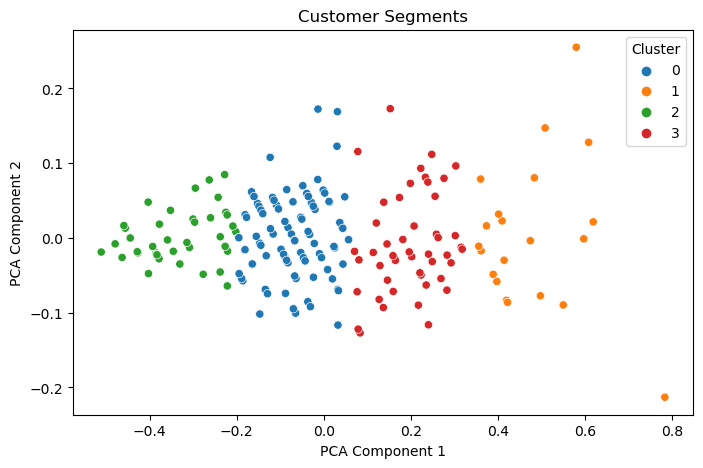

In [11]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score

# Normalize customer features
scaled_data = scaler.fit_transform(customer_profiles[['TotalValue', 'Quantity']])

# Apply K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_data)
customer_profiles['Cluster'] = clusters

# Evaluate clustering
db_index = davies_bouldin_score(scaled_data, clusters)
print("Davies-Bouldin Index:", db_index)

# Visualize clusters using PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=customer_profiles['Cluster'], palette='tab10')
plt.title("Customer Segments")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()
